# simple decoders operating on tca trial factors

In [2]:
%load_ext autoreload
%autoreload 2
import cascade as cas
import flow
import pool
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy as sp
import bottleneck as bt

# except: 
import tensortools as tt
from flow.misc import wordhash
from cascade import utils
from cascade import paths
from cascade import tca
from functools import reduce

# for random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [25]:
for c, m in enumerate(cas.lookups.mice['all12']):
    print(c, m)

0 AS20
1 AS23
2 AS41
3 AS47
4 OA26
5 OA27
6 OA32
7 OA34
8 OA36
9 OA38
10 OA67
11 VF226


In [5]:
# load TCA models and data
mice = cas.lookups.mice['all12']
words = ['respondent' if s in 'OA27' else 'computation' for s in mice]
rank = 15 

# load in a full size tensor
model_list = []
tensor_list = []
id_list = []
bhv_list = []
meta_list = []
for mouse, word in zip(mice, words):
    out = cas.load.load_all_groupday(mouse, word=word, rank=rank, with_model=True, nan_thresh=0.95)  # return   model, ids, tensor, meta, bhv
    model_list.append(out[0])
    tensor_list.append(out[2])
    id_list.append(out[1])
    bhv_list.append(out[4])
    meta_list.append(out[3])

Updated naive cs-ori pairings to match learning.
     135 plus
     270 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     0 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match le

In [40]:
# are go trials
mouse_n = 5
notnaiveboo = ~meta_list[mouse_n]['learning_state'].isin(['naive']).values
# y = meta_list[mouse_n]['trialerror'].isin([0, 3, 5]).values[notnaiveboo]
y = meta_list[mouse_n]['trialerror'].isin([0, 2, 4]).values[notnaiveboo]
# y = meta_list[mouse_n].speed.values[notnaiveboo] > 5
X = model_list[mouse_n].results[15][0].factors[2][notnaiveboo,:]
X = pd.DataFrame(data=X) #.drop(columns=[3])

In [41]:
# Get training and test sets
inds = np.arange(len(y))
X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(X, y, inds, test_size=0.30, random_state=42, shuffle=True)

In [42]:
# fit the initial model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [43]:
# check performance
print('Training set: {}'.format(clf.score(X_train, y_train)))
print('Test set: {}'.format(clf.score(X_test, y_test)))

Training set: 0.8746971270335756
Test set: 0.7989503431570448


Text(0.5, 1.0, 'Feature importance: all features')

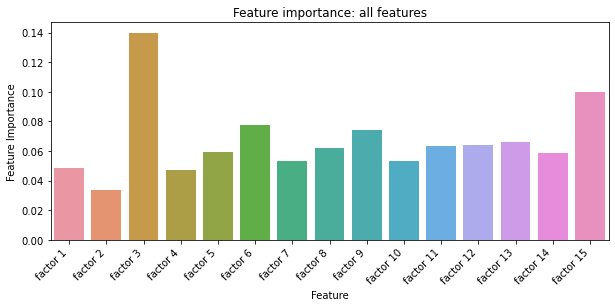

In [44]:
# Find out which features matter for your model:
ft_vals = clf.feature_importances_
ft_names = ['factor {}'.format(s+1) for s in X_train.columns]
plt.figure(figsize=(10,4))
g = sns.barplot(x=ft_names, y=ft_vals)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.set_ylabel('Feature Importance')
g.set_xlabel('Feature')
g.set_title('Feature importance: all features')

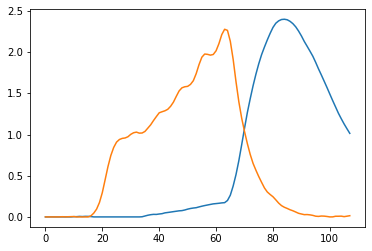

In [45]:
plt.plot(model_list[mouse_n].results[15][0].factors[1][:,3-1])
plt.plot(model_list[mouse_n].results[15][0].factors[1][:,15-1])

In [52]:
meta_list[mouse_n].shape

(8669, 29)

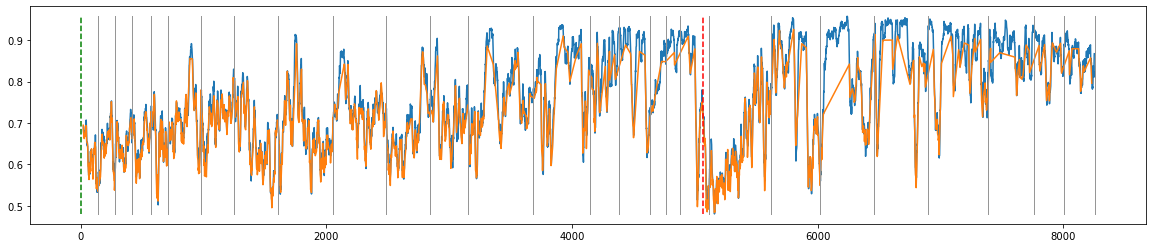

In [54]:
notnaiveboo = ~meta_list[mouse_n]['learning_state'].isin(['naive'])
short_meta = meta_list[mouse_n].loc[notnaiveboo]

allX_prob = clf.predict_proba(X)
prob_vec = np.zeros((len(allX_prob)))
for c, ori in enumerate(np.unique(y)):
    ori_boo = y == ori
    prob_vec[ori_boo] = allX_prob[ori_boo, c]

# calculate change indices for days and reversal/learning
dates = meta_list[mouse_n].reset_index()['date']
udays = {d: c for c, d in enumerate(np.unique(dates))}
ndays = np.diff([udays[i] for i in dates])
day_x = np.where(ndays)[0] + 0.5

# get your learning and reversal start indices 
rev_ind = np.where(short_meta['learning_state'].isin(['reversal1']).values)[0][0]
if np.sum(short_meta['learning_state'].isin(['naive']).values) != 0:
    lear_ind = np.where(short_meta['learning_state'].isin(['naive']).values)[0][-1]
else:
    lear_ind = 0

sm_prob = pd.DataFrame(data=prob_vec).rolling(20).mean()
plt.figure(figsize=(20,4))
# for gonogo in enumerate(np.unique(y)):
goinds = np.where(y)[0]
plt.plot(goinds, sm_prob[y])
goinds = np.where(~y)[0]
plt.plot(goinds, sm_prob[~y])

y_min = np.nanmin(sm_prob)
y_max = np.nanmax(sm_prob)
plt.plot([lear_ind, lear_ind], [y_min, y_max], '--g')
plt.plot([rev_ind, rev_ind], [y_min, y_max], '--r')
# plt.plot([0, len(my_meta_list[0])], [0.5, 0.5], '--k')

if len(day_x) > 0:
    for k in day_x:
        plt.plot([k, k], [y_min, y_max], color='#969696', linewidth=1)

# train a model to discriminate between the three stimuli

In [85]:
# all trials
mouse_n = 5
y = meta_list[mouse_n]['orientation'].values
X = model_list[mouse_n].results[15][0].factors[2]
X = pd.DataFrame(data=X) #.drop(columns=[4, 10, 13])

# Get training and test sets
inds = np.arange(len(y))
X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(X, y, inds, test_size=0.30, random_state=42, shuffle=True)\\

# fit the initial model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# check performance
print('Training set: {}'.format(clf.score(X_train, y_train)))
print('Test set: {}'.format(clf.score(X_test, y_test)))

# Find out which features matter for your model:
ft_vals = clf.feature_importances_
ft_names = ['factor {}'.format(s+1) for s in X_train.columns]
plt.figure(figsize=(10,4))
g = sns.barplot(x=ft_names, y=ft_vals)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.set_ylabel('Feature Importance')
g.set_xlabel('Feature')
g.set_title('Feature importance: all features')

Training set: 1.0
Test set: 1.0
Training set: 0.9996703296703296
Test set: 0.9976923076923077
Training set: 0.9811649808161842
Test set: 0.9495934959349593
Training set: 0.998786959818044
Test set: 0.99115670321896
Training set: 0.9975353482942015
Test set: 0.9878971255673222
Training set: 0.9957152274225445
Test set: 0.9907727797001153
Training set: 1.0
Test set: 1.0
Training set: 1.0
Test set: 1.0
Training set: 0.9988938053097345
Test set: 0.9903225806451613
Training set: 0.9976139346218086
Test set: 0.9938786867000556
Training set: 0.99212447176335
Test set: 0.967741935483871


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Training set: 0.9403500947708775
Test set: 0.9024453694068678


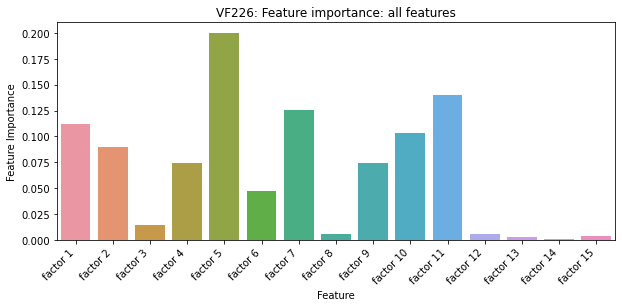

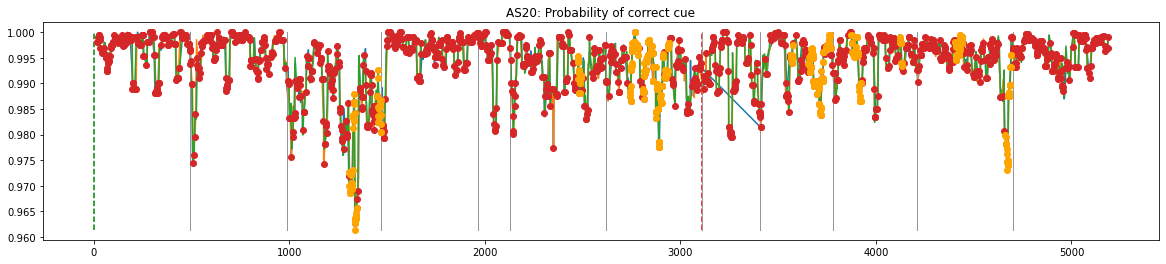

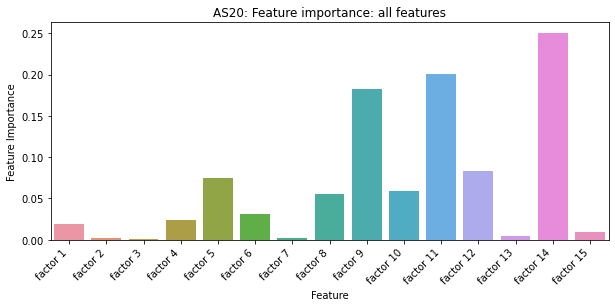

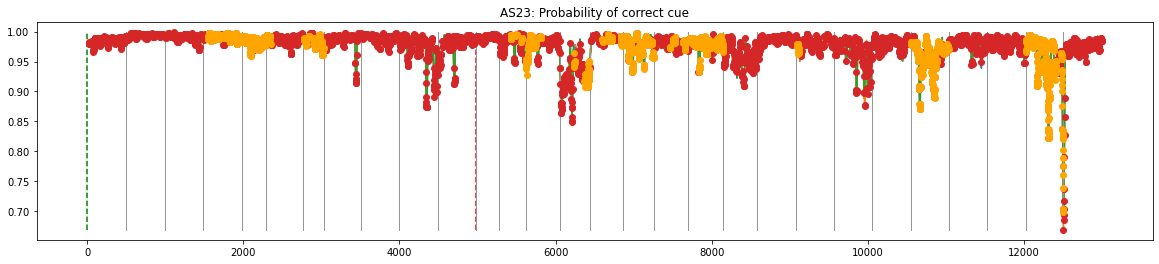

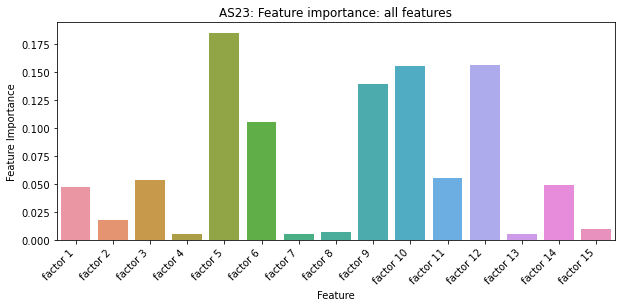

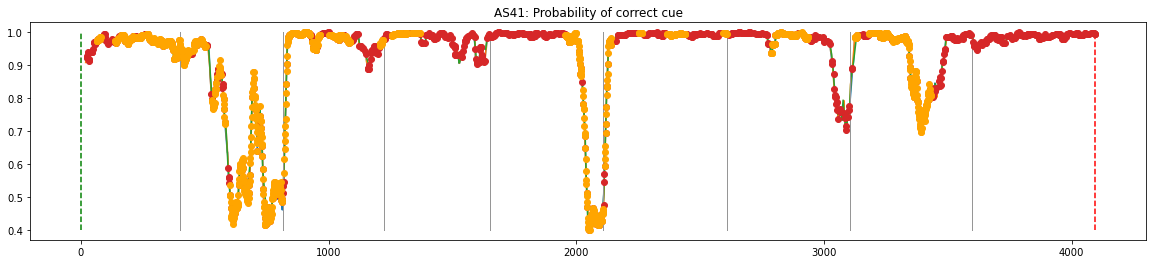

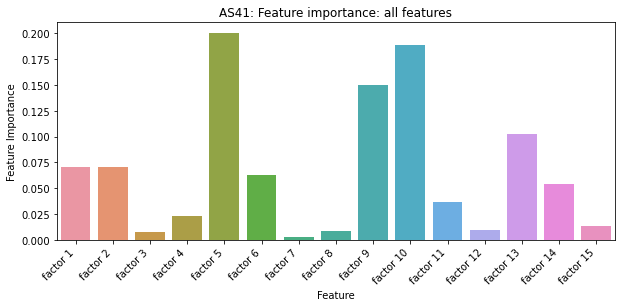

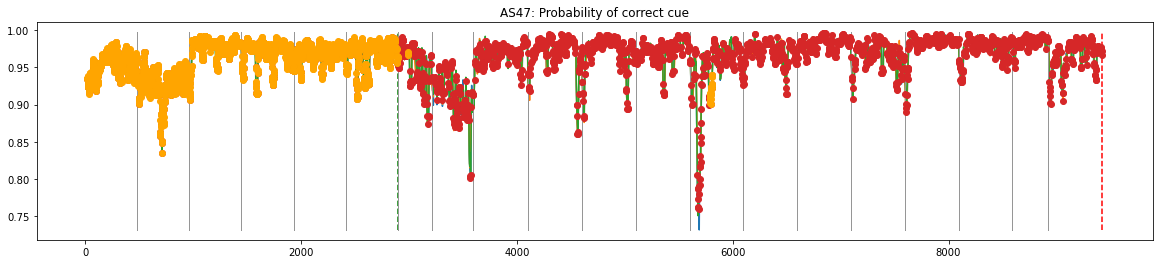

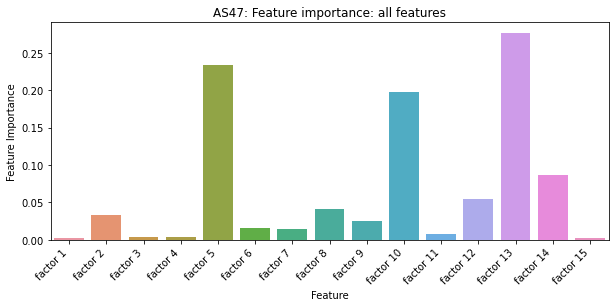

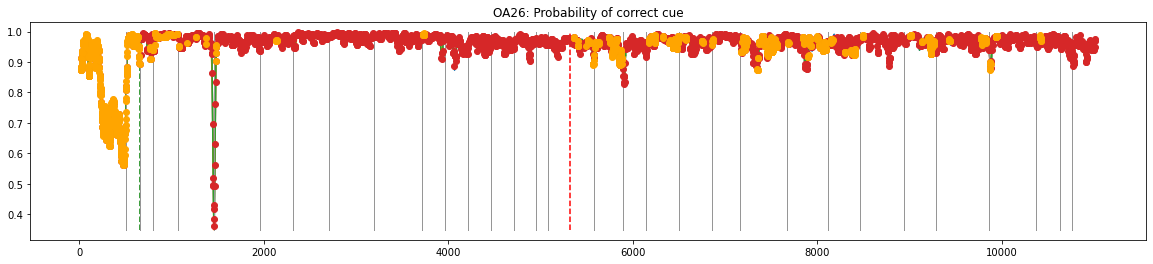

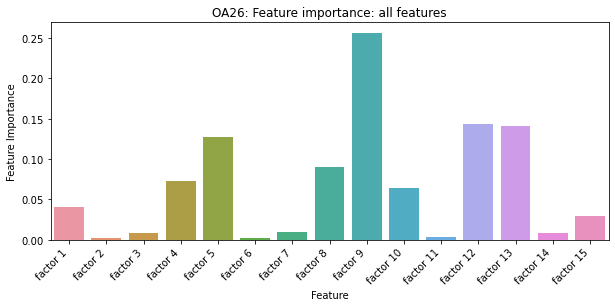

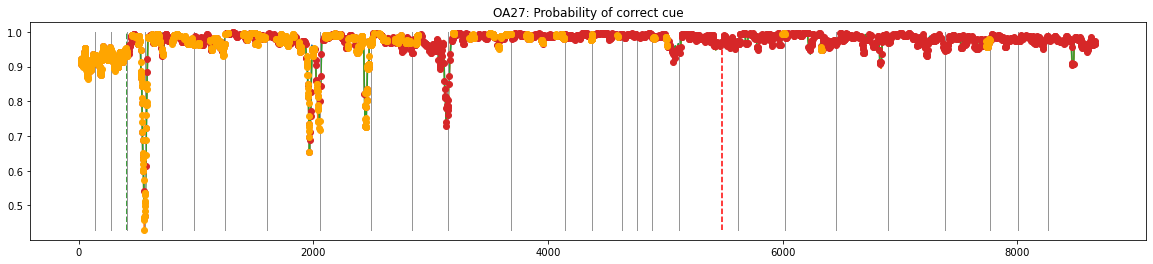

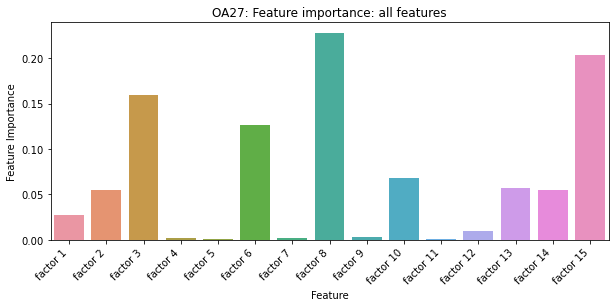

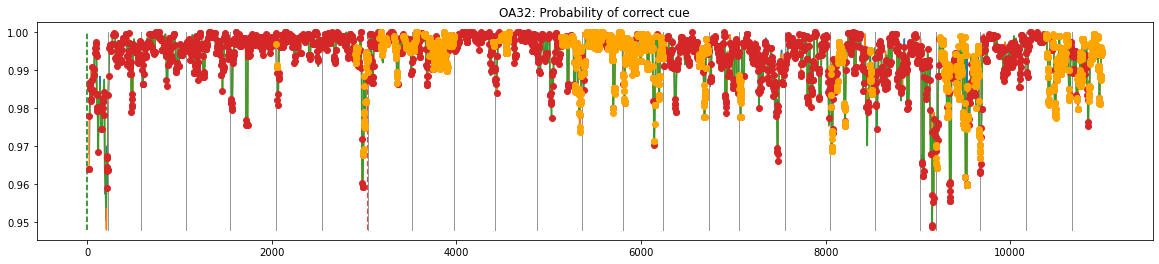

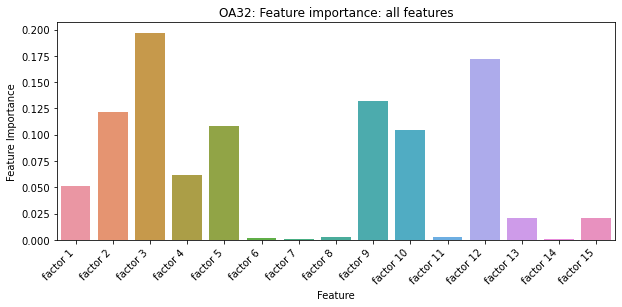

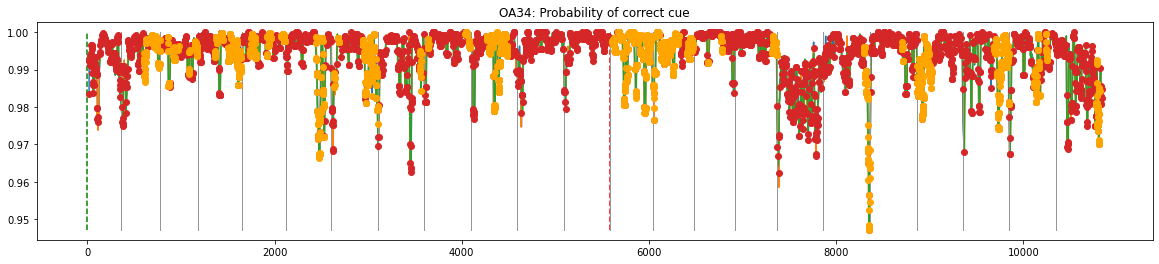

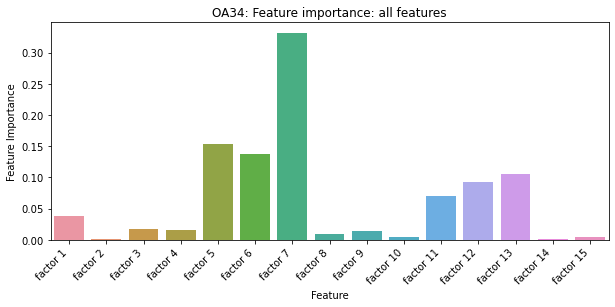

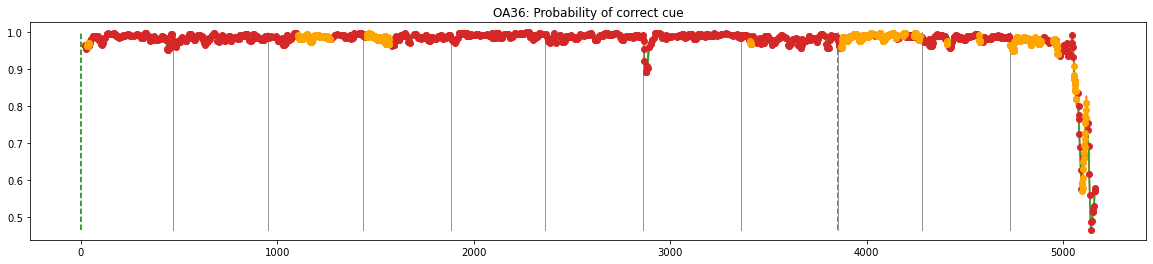

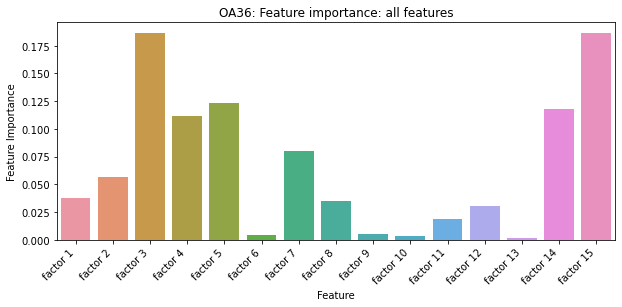

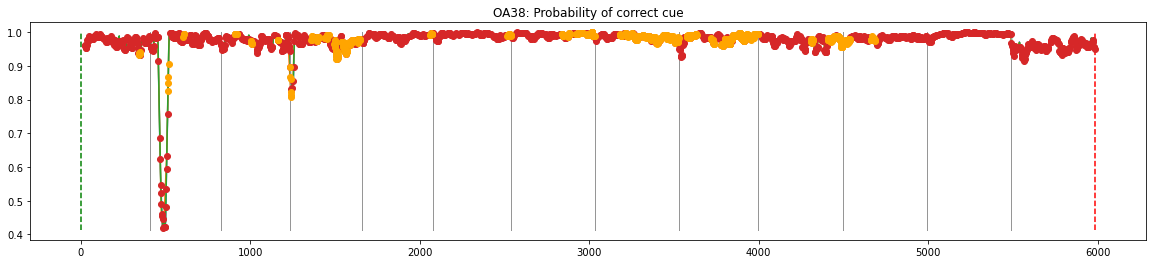

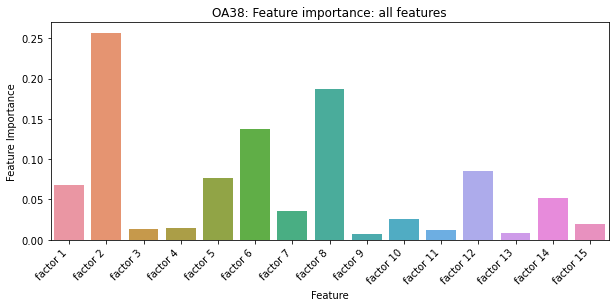

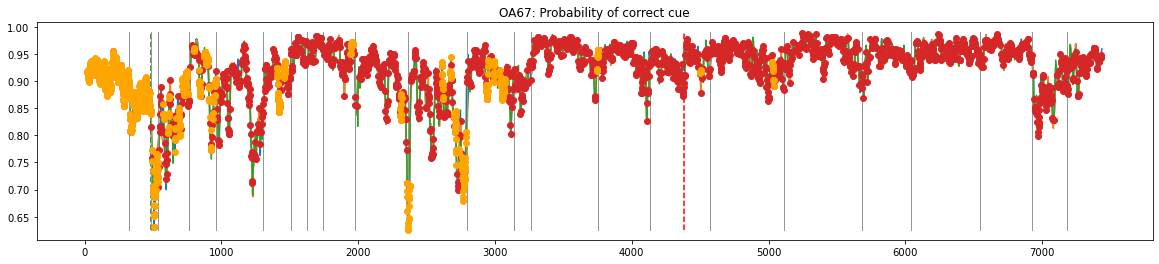

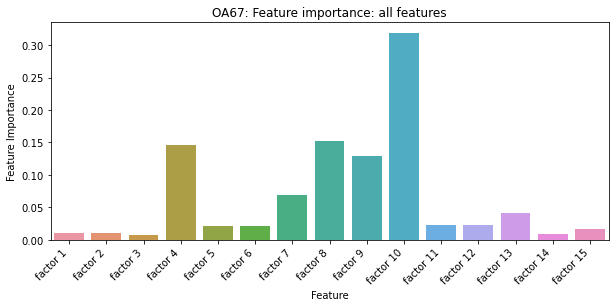

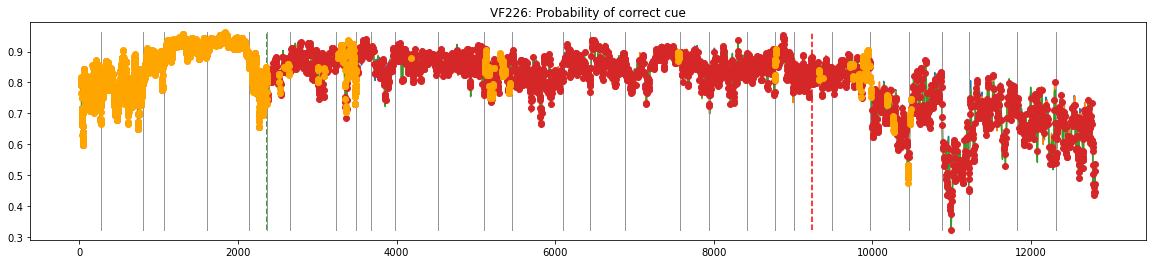

In [114]:
# all trials
for mouse_n in range(len(meta_list)):
# mouse_n = 5
    y = meta_list[mouse_n]['orientation'].values
    X = model_list[mouse_n].results[15][0].factors[2]
    X = pd.DataFrame(data=X) #.drop(columns=[4, 10, 13])

    # Get training and test sets
    inds = np.arange(len(y))
    X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(X, y, inds, test_size=0.30, random_state=42, shuffle=True)

    # fit the initial model
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
    clf.fit(X_train, y_train)

    # check performance
    print('Training set: {}'.format(clf.score(X_train, y_train)))
    print('Test set: {}'.format(clf.score(X_test, y_test)))

    # Find out which features matter for your model:
    ft_vals = clf.feature_importances_
    ft_names = ['factor {}'.format(s+1) for s in X_train.columns]
    plt.figure(figsize=(10,4))
    g = sns.barplot(x=ft_names, y=ft_vals)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
    g.set_ylabel('Feature Importance')
    g.set_xlabel('Feature')
    g.set_title(f'{short_meta.reset_index().mouse.unique()[0]}: Feature importance: all features')


    # PLOT

    notnaiveboo = ~meta_list[mouse_n]['learning_state'].isin(['naive'])
    short_meta = meta_list[mouse_n]

    allX_prob = clf.predict_proba(X)
    prob_vec = np.zeros((len(allX_prob)))
    for c, ori in enumerate(np.unique(y)):
        ori_boo = y == ori
        prob_vec[ori_boo] = allX_prob[ori_boo, c]

    # calculate change indices for days and reversal/learning
    dates = meta_list[mouse_n].reset_index()['date']
    udays = {d: c for c, d in enumerate(np.unique(dates))}
    ndays = np.diff([udays[i] for i in dates])
    day_x = np.where(ndays)[0] + 0.5

    # get your learning and reversal start indices 
    rev_ind = np.where(short_meta['learning_state'].isin(['learning']).values)[0][-1]
    if np.sum(short_meta['learning_state'].isin(['naive']).values) != 0:
        lear_ind = np.where(short_meta['learning_state'].isin(['naive']).values)[0][-1]
    else:
        lear_ind = 0

    sm_prob = pd.DataFrame(data=prob_vec).rolling(20).mean()
    plt.figure(figsize=(20,4))
    for c, cue_type in enumerate(np.unique(y)):
        goinds = np.where(y == cue_type)[0]
        plt.plot(goinds, sm_prob[y == cue_type])
#         goinds = np.where(~(y == cue_type))[0]
#         plt.plot(goinds, sm_prob[~(y == cue_type)])

    y_min = np.nanmin(sm_prob)
    y_max = np.nanmax(sm_prob)
    plt.plot([lear_ind, lear_ind], [y_min, y_max], '--g')
    plt.plot([rev_ind, rev_ind], [y_min, y_max], '--r')
    # plt.plot([0, len(my_meta_list[0])], [0.5, 0.5], '--k')

    if len(day_x) > 0:
        for k in day_x:
            plt.plot([k, k], [y_min, y_max], color='#969696', linewidth=1)

    plt.plot(inds_test, sm_prob.iloc[inds_test], 'o')
#     plt.plot(np.where(short_meta.trialerror.isin([1]).values)[0],
#              sm_prob.iloc[short_meta.trialerror.isin([1]).values], 'o', color='orange')
    plt.plot(np.where(~short_meta['hmm_engaged'].values)[0],
             sm_prob.iloc[~short_meta['hmm_engaged'].values], 'o', color='orange')
    plt.title(f'{short_meta.reset_index().mouse.unique()[0]}: Probability of correct cue')

In [186]:
# Test an ensemble of models removing the most important features

# sort features accoring to their importance in the initial model
drop_order = np.argsort(clf.feature_importances_)
col_drops = X_train.columns[drop_order][::-1]

# fit an ensemble of models 
model_score = []
model_predictions = []
for i in range(len(col_drops)-1):
    
    # make a cumulative list of columns to be dropped in order from highest feature importance to lowest
    drop_list = []
    for c, col in enumerate(col_drops):
        if c <= i:
            drop_list.append(col)
    clf_dropout = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0)
    clf_dropout.fit(X_train.drop(columns=drop_list), y_train)
    
    # see how well it did on the training data
    model_score.append(clf_dropout.score(X_test.drop(columns=drop_list), y_test))
    
    # see how well it did trial by trial the training data
    allX_prob = clf_dropout.predict_proba(X_test.drop(columns=drop_list))
    prob_vec = np.zeros((len(allX_prob)))
    for c, ori in enumerate(np.unique(y_test)):
        ori_boo = y_test == ori
        prob_vec[ori_boo] = allX_prob[ori_boo, c]
    model_predictions.append(prob_vec)
print(model_score)

[0.7796566077003122, 0.7388137356919875, 0.6901664932362123, 0.645681581685744, 0.576222684703434, 0.5330385015608741, 0.44250780437044746, 0.4172736732570239, 0.46097814776274715, 0.4588969823100936, 0.3941207075962539, 0.3829344432882414, 0.3829344432882414, 0.3829344432882414, 0.3829344432882414, 0.3829344432882414, 0.3829344432882414, 0.3829344432882414, 0.3829344432882414]


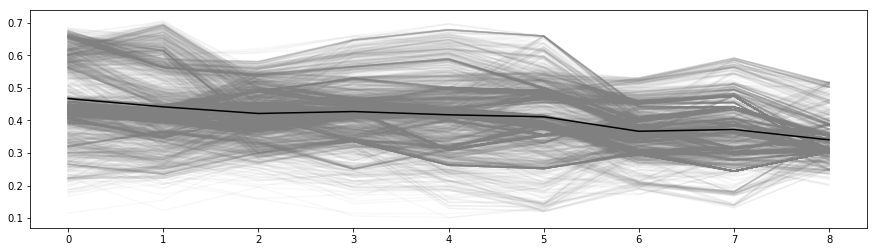

In [128]:
sorter = np.argsort(inds_test)
pred_array = np.vstack(model_predictions)
plt.figure(figsize=(15, 4))
# plt.plot(inds_test[sorter], np.mean(pred_array, axis=0)[sorter])
plt.plot(pred_array, alpha=0.05, color='gray')
plt.plot(np.mean(pred_array, axis=1), color='black')

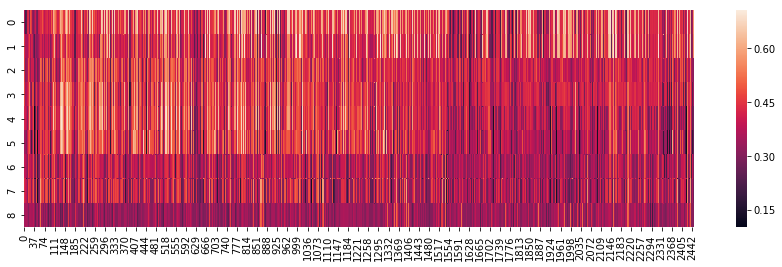

In [129]:
plt.figure(figsize=(15, 4))
sns.heatmap(pred_array[:, sorter])

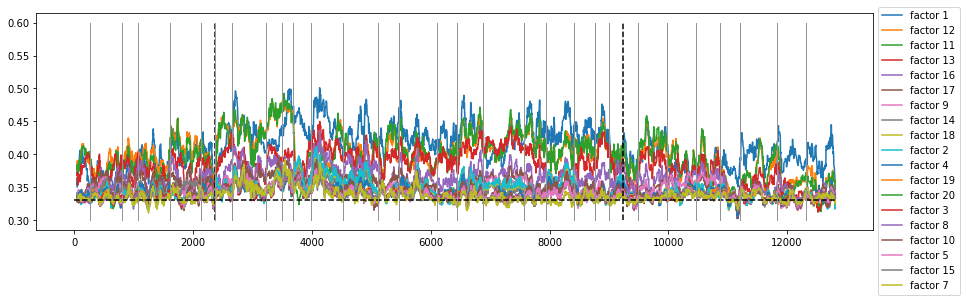

In [187]:
# plt.figure(figsize=(15, 4))
sorter = np.argsort(inds_test)
plt.figure(figsize=(15, 4))
for preds, droppedc in zip(model_predictions, col_drops):
    sm_prob = pd.DataFrame(data=preds[sorter]).rolling(20).mean()
    plt.plot(inds_test[sorter], sm_prob, label='factor {}'.format(droppedc+1))

dates = meta_list[mouse_n].reset_index()['date']
udays = {d: c for c, d in enumerate(np.unique(dates))}
ndays = np.diff([udays[i] for i in dates])
day_x = np.where(ndays)[0] + 0.5

# get your learning and reversal start indices 
rev_ind = np.where(meta_list[mouse_n]['learning_state'].isin(['learning']).values)[0][-1]
if np.sum(meta_list[mouse_n]['learning_state'].isin(['naive']).values) != 0:
    lear_ind = np.where(meta_list[mouse_n]['learning_state'].isin(['naive']).values)[0][-1]
else:
    lear_ind = 0

y_min = .3
y_max = .6
plt.plot([lear_ind, lear_ind], [y_min, y_max], '--k')
plt.plot([rev_ind, rev_ind], [y_min, y_max], '--k')
plt.plot([0, len(meta_list[mouse_n])], [0.33, 0.33], '--k')
# plt.plot([0, len(my_meta_list[0])], [0.5, 0.5], '--k')

if len(day_x) > 0:
    for k in day_x:
        plt.plot([k, k], [y_min, y_max], color='#969696', linewidth=1)

plt.legend(bbox_to_anchor=(1, 1.05))

In [17]:
drop_order = np.argsort(ft_vals)[::-1]
correct_class = []
for dr in drop_order: 
    allX_prob = clf.predict_proba(X_test)
    prob_vec = np.zeros((len(allX_prob)))
    for c, ori in enumerate(np.unique(y_test)):
        ori_boo = y_test == ori
        prob_vec[ori_boo] = allX_prob[ori_boo, c]
    correct_class.append(prob_vec)

In [140]:
allX_prob = clf.predict_proba(X_test)
prob_vec = np.zeros((len(allX_prob)))
for c, ori in enumerate(np.unique(y_test)):
    ori_boo = y_test == ori
    prob_vec[ori_boo] = allX_prob[ori_boo, c]

array([1.  , 1.  , 0.83, ..., 0.97, 0.86, 0.9 ])

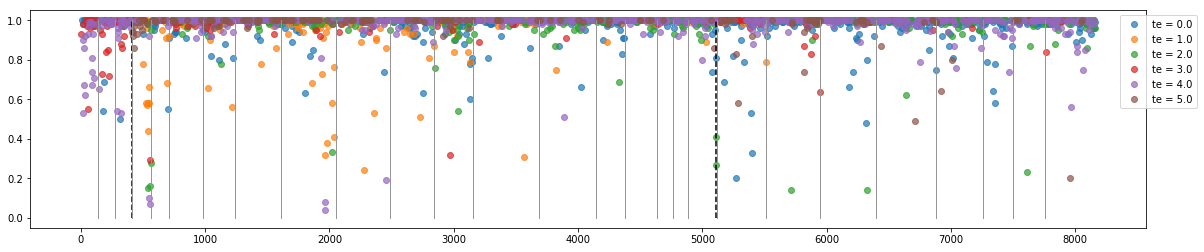

In [20]:
# calculate change indices for days and reversal/learning
dates = meta_list[mouse_n].reset_index()['date']
udays = {d: c for c, d in enumerate(np.unique(dates))}
ndays = np.diff([udays[i] for i in dates])
day_x = np.where(ndays)[0] + 0.5

# get your learning and reversal start indices 
rev_ind = np.where(meta_list[mouse_n]['learning_state'].isin(['learning']).values)[0][-1]
if np.sum(meta_list[mouse_n]['learning_state'].isin(['naive']).values) != 0:
    lear_ind = np.where(meta_list[mouse_n]['learning_state'].isin(['naive']).values)[0][-1]
else:
    lear_ind = 0

sorter = np.argsort(inds_test)
sm_prob = pd.DataFrame(data=prob_vec).rolling(10).mean()
plt.figure(figsize=(20,4))
te_vec = meta_list[mouse_n]['trialerror'].values[inds_test][sorter]
for i in np.unique(te_vec):
    te_single = prob_vec[sorter][te_vec == i]
    te_inds = inds_test[sorter][te_vec == i]
    plt.plot(te_inds, te_single, 'o', alpha=0.7, label='te = {}'.format(i))
plt.legend(bbox_to_anchor=(1.05, 1))
y_min = 0
y_max = 1
plt.plot([lear_ind, lear_ind], [y_min, y_max], '--k')
plt.plot([rev_ind, rev_ind], [y_min, y_max], '--k')
# plt.plot([0, len(my_meta_list[0])], [0.5, 0.5], '--k')

if len(day_x) > 0:
    for k in day_x:
        plt.plot([k, k], [y_min, y_max], color='#969696', linewidth=1)

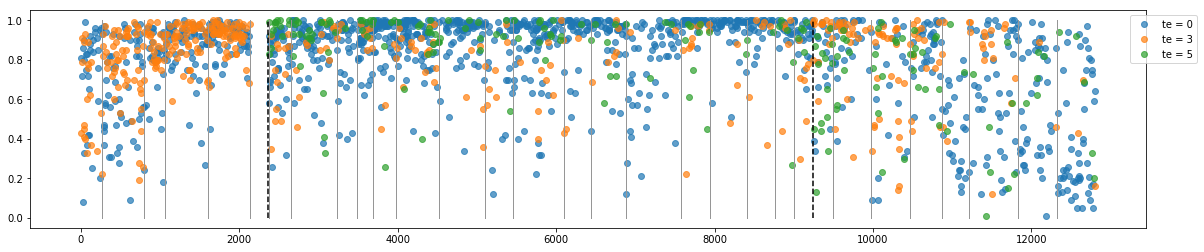

In [159]:
sorter = np.argsort(inds_test)
sm_prob = pd.DataFrame(data=prob_vec).rolling(10).mean()
plt.figure(figsize=(20,4))
te_vec = meta_list[mouse_n]['trialerror'].values[inds_test][sorter]
for i in [0, 3, 5]:
    te_single = prob_vec[sorter][te_vec == i]
    te_inds = inds_test[sorter][te_vec == i]
    plt.plot(te_inds, te_single, 'o', alpha=0.7, label='te = {}'.format(i))
plt.legend(bbox_to_anchor=(1.05, 1))

y_min = 0
y_max = 1
plt.plot([lear_ind, lear_ind], [y_min, y_max], '--k')
plt.plot([rev_ind, rev_ind], [y_min, y_max], '--k')
# plt.plot([0, len(my_meta_list[0])], [0.5, 0.5], '--k')

if len(day_x) > 0:
    for k in day_x:
        plt.plot([k, k], [y_min, y_max], color='#969696', linewidth=1)

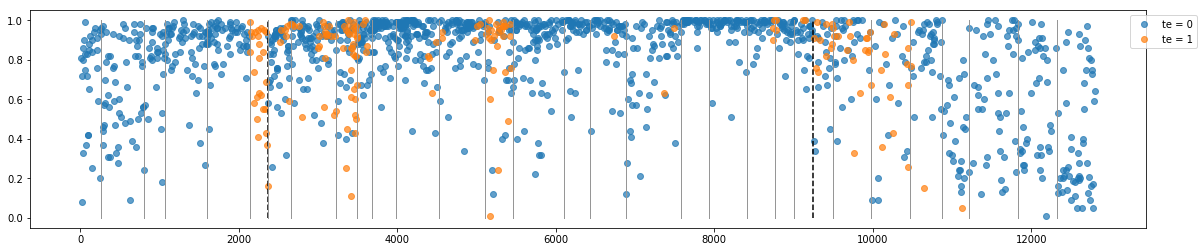

In [160]:
sorter = np.argsort(inds_test)
sm_prob = pd.DataFrame(data=prob_vec).rolling(10).mean()
plt.figure(figsize=(20,4))
te_vec = meta_list[mouse_n]['trialerror'].values[inds_test][sorter]
for i in [0, 1]:
    te_single = prob_vec[sorter][te_vec == i]
    te_inds = inds_test[sorter][te_vec == i]
    plt.plot(te_inds, te_single, 'o', alpha=0.7, label='te = {}'.format(i))
plt.legend(bbox_to_anchor=(1.05, 1))

y_min = 0
y_max = 1
plt.plot([lear_ind, lear_ind], [y_min, y_max], '--k')
plt.plot([rev_ind, rev_ind], [y_min, y_max], '--k')
# plt.plot([0, len(my_meta_list[0])], [0.5, 0.5], '--k')

if len(day_x) > 0:
    for k in day_x:
        plt.plot([k, k], [y_min, y_max], color='#969696', linewidth=1)

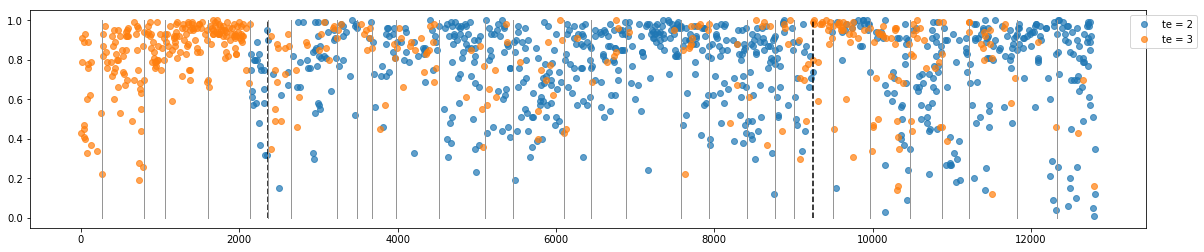

In [161]:
sorter = np.argsort(inds_test)
sm_prob = pd.DataFrame(data=prob_vec).rolling(10).mean()
plt.figure(figsize=(20,4))
te_vec = meta_list[mouse_n]['trialerror'].values[inds_test][sorter]
for i in [2, 3]:
    te_single = prob_vec[sorter][te_vec == i]
    te_inds = inds_test[sorter][te_vec == i]
    plt.plot(te_inds, te_single, 'o', alpha=0.7, label='te = {}'.format(i))
plt.legend(bbox_to_anchor=(1.05, 1))

y_min = 0
y_max = 1
plt.plot([lear_ind, lear_ind], [y_min, y_max], '--k')
plt.plot([rev_ind, rev_ind], [y_min, y_max], '--k')
# plt.plot([0, len(my_meta_list[0])], [0.5, 0.5], '--k')

if len(day_x) > 0:
    for k in day_x:
        plt.plot([k, k], [y_min, y_max], color='#969696', linewidth=1)

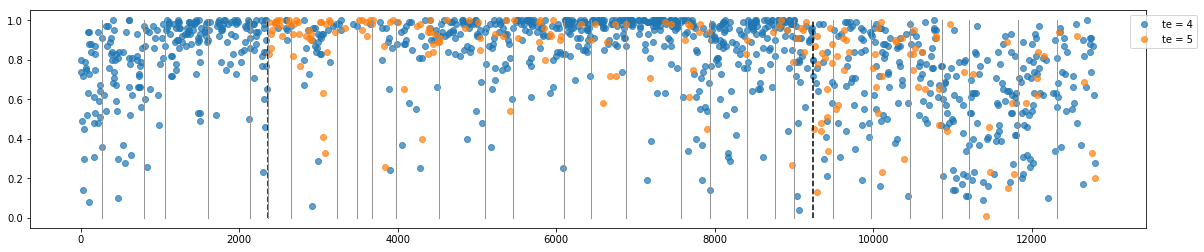

In [162]:
sorter = np.argsort(inds_test)
sm_prob = pd.DataFrame(data=prob_vec).rolling(10).mean()
plt.figure(figsize=(20,4))
te_vec = my_meta_list[1]['trialerror'].values[inds_test][sorter]
for i in [4, 5]:
    te_single = prob_vec[sorter][te_vec == i]
    te_inds = inds_test[sorter][te_vec == i]
    plt.plot(te_inds, te_single, 'o', alpha=0.7, label='te = {}'.format(i))
plt.legend(bbox_to_anchor=(1.05, 1))

y_min = 0
y_max = 1
plt.plot([lear_ind, lear_ind], [y_min, y_max], '--k')
plt.plot([rev_ind, rev_ind], [y_min, y_max], '--k')
# plt.plot([0, len(my_meta_list[0])], [0.5, 0.5], '--k')

if len(day_x) > 0:
    for k in day_x:
        plt.plot([k, k], [y_min, y_max], color='#969696', linewidth=1)